In [2]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from tqdm import tqdm
import soundfile as sf

In [3]:
import glob
import srmrpy as srmr
import mir_eval
import pystoi
def get_audio_list(path, file_types = ('.npy')):
    search_path = path + '/**/*'
    audio_list = []
    for file_type in file_types:
        audio_list.extend(glob.glob(search_path+file_type, recursive=True))
    return audio_list

In [5]:
clean_list = get_audio_list('/home/martin/deep-dereverb/data/test/clean/')
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/test/real/')
clean_list.sort(); reverb_list.sort()
reverb = np.load(reverb_list[0])
clean = np.load(clean_list[0]) 

In [6]:
stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
mag_reverb = np.abs(stft_reverb)
pha_reverb = np.angle(stft_reverb)

stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
mag_clean = np.abs(stft_clean)
pha_clean = np.angle(stft_clean)

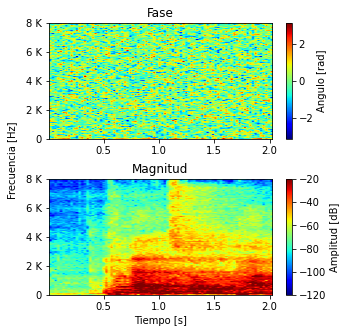

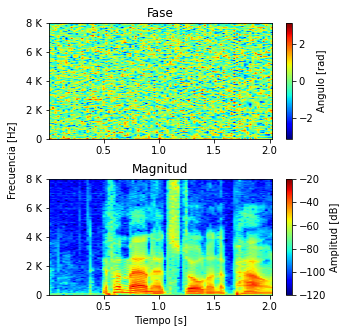

In [7]:
fig = plt.figure(1, figsize=(5,5))
plt.subplot(2,1,1)
plt.title('Fase')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
plt.specgram(reverb, Fs=16000, NFFT=512, noverlap=128, mode='angle', cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Angulo [rad]')

plt.subplot(2,1,2)
plt.title('Magnitud')
plt.specgram(reverb, Fs=16000, NFFT=512, noverlap=128, mode='magnitude', cmap='jet', vmax=-20, vmin=-120)
cbar = plt.colorbar()
plt.xlabel('Tiempo [s]')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
fig.text(0.01, 0.5, 'Frecuencia [Hz]', va='center', rotation='vertical')
cbar.set_label('Amplitud [dB]')
plt.subplots_adjust(hspace=0.35)
plt.savefig('imagenes/fase_reverb', bbox_inches='tight')

fig = plt.figure(2, figsize=(5,5))
plt.subplot(2,1,1)
plt.title('Fase')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
plt.specgram(clean, Fs=16000, NFFT=512, noverlap=128, mode='angle', cmap='jet')
cbar = plt.colorbar()
cbar.set_label('Angulo [rad]')

plt.subplot(2,1,2)
plt.title('Magnitud')
plt.specgram(clean, Fs=16000, NFFT=512, noverlap=128, mode='magnitude', cmap='jet', vmax=-20, vmin=-120)
cbar = plt.colorbar()
plt.xlabel('Tiempo [s]')
plt.yticks([0, 2000, 4000, 6000, 8000], ['0', '2 K', '4 K', '6 K', '8 K'])
fig.text(0.01, 0.5, 'Frecuencia [Hz]', va='center', rotation='vertical')
cbar.set_label('Amplitud [dB]')
plt.subplots_adjust(hspace=0.35)
plt.savefig('imagenes/fase_clean', bbox_inches='tight')

In [59]:
def get_specs(clean_path, reverb_path):
    reverb = np.load(reverb_path)
    clean = np.load(clean_path) 
    stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    mag_reverb = np.abs(stft_reverb)
    pha_reverb = np.angle(stft_reverb)

    stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    mag_clean = np.abs(stft_clean)
    pha_clean = np.angle(stft_clean)
    return mag_clean, pha_reverb, clean


def rec_fasereverb(mag_clean, pha_reverb):
    stft_build = mag_clean * np.exp(1j*pha_reverb)
    recover = librosa.istft(stft_build, hop_length=128, win_length=512)
    return recover


def rec_grifininit(mag_clean, pha_reverb, it=100):
    #stft_build = mag_clean * np.exp(1j*pha_reverb)
    stft_build = mag_clean
    recover = martinlim(stft_build, pha_reverb, n_iter=it, hop_length=128, win_length=512, init=None, random_state=1)
    return recover


def rec_griffin(mag_clean, pha_reverb, it=100):
    recover = librosa.griffinlim(mag_clean, n_iter=it, hop_length=128, win_length=512, init='random', random_state=1)
    return recover


def get_metricas(clean, reverb, fs):
    SRMR = srmr.srmr(reverb, fs)[0]
    SDR, _, _, _ = mir_eval.separation.bss_eval_sources(clean, reverb, compute_permutation=True)
    ESTOI = pystoi.stoi(clean, reverb, fs, extended = True)
    return SRMR, SDR[0], ESTOI


def martinlim(S, pha_reverb, n_iter=32, hop_length=None, win_length=None, window='hann',
               center=True, dtype=np.float32, length=None, pad_mode='reflect',
               momentum=0.99, init=None, random_state=None):

    if random_state is None:
        rng = np.random
    elif isinstance(random_state, int):
        rng = np.random.RandomState(seed=random_state)
    elif isinstance(random_state, np.random.RandomState):
        rng = random_state

    if momentum > 1:
        warnings.warn('Griffin-Lim with momentum={} > 1 can be unstable. '
                      'Proceed with caution!'.format(momentum))
    elif momentum < 0:
        raise ParameterError('griffinlim() called with momentum={} < 0'.format(momentum))

    # Infer n_fft from the spectrogram shape
    n_fft = 2 * (S.shape[0] - 1)

    # using complex64 will keep the result to minimal necessary precision
    angles = np.empty(S.shape, dtype=np.complex64)
    if init == 'random':
        # randomly initialize the phase
        angles[:] = np.exp(2j * np.pi * rng.rand(*S.shape))
    elif init is None:
        # Inicio con la fase del espectro de entrada
        angles[:] = np.exp(1j*pha_reverb)
    else:
        raise ParameterError("init={} must either None or 'random'".format(init))

    # And initialize the previous iterate to 0
    rebuilt = 0.

    for _ in range(n_iter):
        # Store the previous iterate
        tprev = rebuilt

        # Invert with our current estimate of the phases
        inverse = librosa.istft(S * angles, hop_length=hop_length, win_length=win_length,
                        window=window, center=center, dtype=dtype, length=length)

        # Rebuild the spectrogram
        rebuilt = librosa.stft(inverse, n_fft=n_fft, hop_length=hop_length,
                       win_length=win_length, window=window, center=center,
                       pad_mode=pad_mode)

        # Update our phase estimates
        angles[:] = rebuilt - (momentum / (1 + momentum)) * tprev
        angles[:] /= np.abs(angles) + 1e-16

    # Return the final phase estimates
    return librosa.istft(S * angles, hop_length=hop_length, win_length=win_length,
                 window=window, center=center, dtype=dtype, length=length)

In [9]:
clean_list = get_audio_list('/home/martin/deep-dereverb/data/test/clean/')
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/test/real/')
clean_list.sort(); reverb_list.sort()

In [32]:
import IPython
params_1 = []
params_2 = []
params_3 = []
for clean_path, reverb_path in tqdm(zip(clean_list, reverb_list[:100]), total=100):
    mag_clean, pha_reverb, audio_clean = get_specs(clean_path, reverb_path)
    recover_1 = rec_fasereverb(mag_clean, pha_reverb)
    recover_2 = rec_grifininit(mag_clean, pha_reverb, it=10)
    recover_3 = rec_griffin(mag_clean, pha_reverb, it=10)
    params_1.append([get_metricas(audio_clean, recover_1, 16000)])
    params_2.append([get_metricas(audio_clean, recover_2, 16000)])
    params_3.append([get_metricas(audio_clean, recover_3, 16000)])    
    IPython.display.display(IPython.display.Audio(audio_clean, rate=16000))
    IPython.display.display(IPython.display.Audio(recover_1, rate=16000))
    IPython.display.display(IPython.display.Audio(recover_2, rate=16000))
    IPython.display.display(IPython.display.Audio(recover_3, rate=16000))
    #sf.write('audios/recover_phasereverb.wav', recover_1, 16000)
    #sf.write('audios/recover_griffin-init.wav', recover_2 ,16000)
    #sf.write('audios/recover_griffin.wav', recover_3, 16000)
    #import pdb; pdb.set_trace()

  0%|                                                                                                                | 0/100 [00:00<?, ?it/s]

> /tmp/ipykernel_31884/2661157829.py(5)<module>()
      3 params_2 = []
      4 params_3 = []
----> 5 for clean_path, reverb_path in tqdm(zip(clean_list, reverb_list[:100]), total=100):
      6     mag_clean, pha_reverb, audio_clean = get_specs(clean_path, reverb_path)
      7     recover_1 = rec_fasereverb(mag_clean, pha_reverb)

ipdb> exit


  0%|                                                                                                                | 0/100 [00:20<?, ?it/s]


BdbQuit: 

In [29]:
srmr_, sdr_, estoi_ = [], [], []
for param in params_1:
    srmr_.append(param[0][0])
    sdr_.append(param[0][1])
    estoi_.append(param[0][2])
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(srmr_), np.median(sdr_), np.median(estoi_)))

SRMR: 4.23, SDR: 2.11, ESTOI: 0.89


In [30]:
srmr_, sdr_, estoi_ = [], [], []
for param in params_2:
    srmr_.append(param[0][0])
    sdr_.append(param[0][1])
    estoi_.append(param[0][2])
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(srmr_), np.median(sdr_), np.median(estoi_)))

SRMR: 3.89, SDR: 3.26, ESTOI: 0.97


In [31]:
srmr_, sdr_, estoi_ = [], [], []
for param in params_3:
    srmr_.append(param[0][0])
    sdr_.append(param[0][1])
    estoi_.append(param[0][2])
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.mean(srmr_), np.mean(sdr_), np.mean(estoi_)))

SRMR: 4.74, SDR: -4.72, ESTOI: 0.95


# Estudiando numero de iteraciones

In [128]:
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder

PESOS = '/home/martin/deep-dereverb/model/ckpts/reales/weights.03-0.0028.hdf5'
modelo = autoencoder()
modelo.load_weights(PESOS)
fs = 16000
indices = np.random.choice(np.arange(0,len(reverb_list)), 100)
SRMR_reverb = []                                                                                                                         
SDR_reverb = []                                                                                                                          
ESTOI_reverb = []                                                                                                                        

SRMR_dereverb = []                                                                                                                       
SDR_dereverb = []                                                                                                                        
ESTOI_dereverb = [] 

for i in tqdm(range(0,100,5)):
    srmr_aux = 0
    sdr_aux = 0
    estoi_aux = 0
    for j in indices:
        audio_in = np.load(reverb_list[j])
        audio_target = np.load(clean_list[j])

        espectro_in = gen_stft(audio_in)
        espectro_target = gen_stft(audio_target)

        espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
        espectro_out = espectro_out.reshape(256,256)

        dereverb = frame_to_raw(espectro_out, i)
        clean = audio_target
        reverb = audio_in

        # get metrics for clean-dereverb                                                                                                     
        srmr_, sdr, estoi = get_metricas(clean, dereverb, fs)                                                                                 
        srmr_aux += srmr_
        sdr_aux += sdr
        estoi_aux += estoi

    SRMR_dereverb.append(srmr_aux/len(indices))                                                                                                           
    SDR_dereverb.append(sdr_aux/len(indices))                                                                                                             
    ESTOI_dereverb.append(estoi_aux/len(indices))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [11:55<00:00, 35.78s/it]


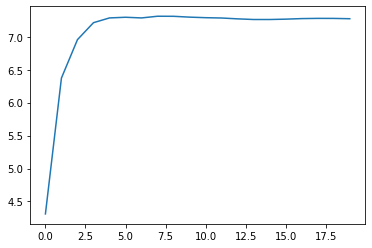

In [129]:
plt.plot(SRMR_dereverb)

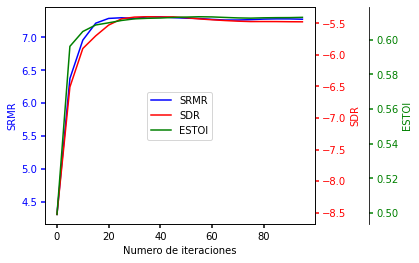

In [132]:
import matplotlib.pyplot as plt


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots(1)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(np.arange(0,100,5), SRMR_dereverb, "b-", label="SRMR")
p2, = par1.plot(np.arange(0,100,5), SDR_dereverb, "r-", label="SDR")
p3, = par2.plot(np.arange(0,100,5), ESTOI_dereverb, "g-", label="ESTOI")

#host.set_xlim(0, 2)
#host.set_ylim(0, 2)
#par1.set_ylim(0, 4)
#par2.set_ylim(1, 65)

host.set_xlabel("Numero de iteraciones")
host.set_ylabel("SRMR")
par1.set_ylabel("SDR")
par2.set_ylabel("ESTOI")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines], loc='center')
plt.savefig('imagenes/iteraciones.png')
plt.show()

<Figure size 432x288 with 0 Axes>

# Reconstruyo audios con reverb

In [86]:
def frame_to_raw(frame, it=100):

    frame = denormalise(frame)
    #Escala logaritmica
    frame_lin = librosa.db_to_amplitude(frame)

    #Necesito agregar el bin de frecuencia que le saque.
    frame_lin_pad = np.pad(frame_lin,((0,1),(0,0)), 'minimum') #Ojoooooo!

    #Para antitransformar necesito la fase. Puedo estimar a partir de griffim lim 
    frame_raw = librosa.griffinlim(frame_lin_pad, 
                                        n_iter=it,
                                        hop_length=128, 
                                        win_length=512,
                                        random_state=1)
    return frame_raw


def frame_to_raw_m(frame,  reverb, it=100):
    stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    pha_reverb = np.angle(stft_reverb)
    
    frame = denormalise(frame)
    #Escala logaritmica
    frame_lin = librosa.db_to_amplitude(frame)

    #Necesito agregar el bin de frecuencia que le saque.
    frame_lin_pad = np.pad(frame_lin,((0,1),(0,0)), 'minimum') #Ojoooooo!

    #Para antitransformar necesito la fase. Puedo estimar a partir de griffim lim 
    frame_raw = martinlim(frame_lin_pad, pha_reverb, init=None, n_iter=it, hop_length=128, win_length=512, random_state=1)
    return frame_raw


def frame_to_raw_f(frame, reverb):
    stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
    pha_reverb = np.angle(stft_reverb)


    frame = denormalise(frame)
    #Escala logaritmica
    frame_lin = librosa.db_to_amplitude(frame)

    #Necesito agregar el bin de frecuencia que le saque.
    frame_lin_pad = np.pad(frame_lin,((0,1),(0,0)), 'minimum') #Ojoooooo!

    stft_build = frame_lin_pad * np.exp(1j*pha_reverb)
    recover = librosa.istft(stft_build, hop_length=128, win_length=512)
    return recover


def gen_stft(audio):
    #Genero las STFT
    stft_ = librosa.stft(audio, n_fft=512, hop_length=128)[:-1,:]# Descarto altas frecuencias
    stft_ = np.abs(stft_)
    #Escala logaritmica
    log_stft_ = librosa.amplitude_to_db(stft_)

    #Normalizacion
    norm_stft_ = normalise(log_stft_)
    return norm_stft_


def denormalise(array):
    EPS = np.finfo(float).eps
    array_min = -75
    array_max = 65
    array = (array * (array_max - array_min)) + array_min
    return array

def normalise(array):
    EPS = np.finfo(float).eps
    array_min = -75
    array_max = 65
    norm_array = (array - array_min) / (array_max - array_min + EPS)
    return norm_array 

In [133]:
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder

PESOS = '/home/martin/deep-dereverb/model/ckpts/reales/weights.03-0.0028.hdf5'
modelo = autoencoder()
modelo.load_weights(PESOS)
fs = 16000
indices = np.random.choice(np.arange(0,len(reverb_list)), 100)

Metiendo fase reverberada de una

In [141]:
SRMR_reverb = []                                                                                                                         
SDR_reverb = []                                                                                                                          
ESTOI_reverb = []                                                                                                                        

SRMR_dereverb = []                                                                                                                       
SDR_dereverb = []                                                                                                                        
ESTOI_dereverb = [] 

for i in tqdm(indices):
    audio_in = np.load(reverb_list[i])
    audio_target = np.load(clean_list[i])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    dereverb = frame_to_raw_f(espectro_out, audio_in)
    #clean = frame_to_raw_f(espectro_target, audio_target)
    #reverb = frame_to_raw_f(espectro_in, audio_in)
    clean = audio_target
    reverb = audio_in
    
    # get metriciis for clean-reverb                                                                                                       
    srmr_, sdr, estoi = get_metricas(clean, reverb, fs)                                                                                   
    SRMR_reverb.append(srmr_)                                                                                                             
    SDR_reverb.append(sdr)                                                                                                               
    ESTOI_reverb.append(estoi)                                                                                                           

    # get metrics for clean-dereverb                                                                                                     
    srmr_, sdr, estoi = get_metricas(clean, dereverb, fs)                                                                                 
    SRMR_dereverb.append(srmr_)                                                                                                           
    SDR_dereverb.append(sdr)                                                                                                             
    ESTOI_dereverb.append(estoi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s]


In [142]:
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(SRMR_reverb), np.median(SDR_reverb), np.median(ESTOI_reverb)))
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(SRMR_dereverb), np.median(SDR_dereverb), np.median(ESTOI_dereverb)))

SRMR: 1.73, SDR: -3.11, ESTOI: 0.29
SRMR: 6.26, SDR: 1.16, ESTOI: 0.60


Iterando desde fase reverb

In [143]:
SRMR_reverb = []                                                                                                                         
SDR_reverb = []                                                                                                                          
ESTOI_reverb = []                                                                                                                        

SRMR_dereverb = []                                                                                                                       
SDR_dereverb = []                                                                                                                        
ESTOI_dereverb = [] 

for i in tqdm(indices):
    audio_in = np.load(reverb_list[i])
    audio_target = np.load(clean_list[i])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    dereverb = frame_to_raw_m(espectro_out, audio_in, 10)
    #clean = frame_to_raw_m(espectro_target, audio_target, 10)
    #reverb = frame_to_raw_m(espectro_in, audio_in, 10)
    clean = audio_target
    reverb = audio_in    
    
    # get metriciis for clean-reverb                                                                                                       
    srmr_, sdr, estoi = get_metricas(clean, reverb, fs)                                                                                   
    SRMR_reverb.append(srmr_)                                                                                                             
    SDR_reverb.append(sdr)                                                                                                               
    ESTOI_reverb.append(estoi)                                                                                                           

    # get metrics for clean-dereverb                                                                                                     
    srmr_, sdr, estoi = get_metricas(clean, dereverb, fs)                                                                                 
    SRMR_dereverb.append(srmr_)                                                                                                           
    SDR_dereverb.append(sdr)                                                                                                             
    ESTOI_dereverb.append(estoi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


In [145]:
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(SRMR_reverb), np.median(SDR_reverb), np.median(ESTOI_reverb)))
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(SRMR_dereverb), np.median(SDR_dereverb), np.median(ESTOI_dereverb)))

SRMR: 1.73, SDR: -3.11, ESTOI: 0.29
SRMR: 6.86, SDR: -1.73, ESTOI: 0.62


Estimando con griffin lim desde random

In [146]:
SRMR_reverb = []                                                                                                                         
SDR_reverb = []                                                                                                                          
ESTOI_reverb = []                                                                                                                        

SRMR_dereverb = []                                                                                                                       
SDR_dereverb = []                                                                                                                        
ESTOI_dereverb = [] 

for i in tqdm(indices):
    audio_in = np.load(reverb_list[i])
    audio_target = np.load(clean_list[i])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    dereverb = frame_to_raw(espectro_out)
    #clean = frame_to_raw(espectro_target)
    #reverb = frame_to_raw(espectro_in)
    
    clean = audio_target
    reverb = audio_in
    
    # get metriciis for clean-reverb                                                                                                       
    srmr_, sdr, estoi = get_metricas(clean, reverb, fs)                                                                                   
    SRMR_reverb.append(srmr_)                                                                                                             
    SDR_reverb.append(sdr)                                                                                                               
    ESTOI_reverb.append(estoi)                                                                                                           

    # get metrics for clean-dereverb                                                                                                     
    srmr_, sdr, estoi = get_metricas(clean, dereverb, fs)                                                                                 
    SRMR_dereverb.append(srmr_)                                                                                                           
    SDR_dereverb.append(sdr)                                                                                                             
    ESTOI_dereverb.append(estoi)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


In [147]:
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(SRMR_reverb), np.median(SDR_reverb), np.median(ESTOI_reverb)))
print('SRMR: {:.2f}, SDR: {:.2f}, ESTOI: {:.2f}'.format(np.median(SRMR_dereverb), np.median(SDR_dereverb), np.median(ESTOI_dereverb)))

SRMR: 1.73, SDR: -3.11, ESTOI: 0.29
SRMR: 6.97, SDR: -6.03, ESTOI: 0.62
